# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует злокачественной опухоли (M), 
        0 --- доброкачественной (B).

    
    """
    
    data = pandas.read_csv(path_to_csv).sample(frac=1)
    y = data['label'].values
    y = np.where(y == 'M', 1, 0).astype('int8')
    X = data.drop('label', axis=1).values.astype('float64')
    
    return X, y
    
    

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    data = pandas.read_csv(path_to_csv).sample(frac=1)
    y = data['label'].values.astype('int8')
    X = data.drop('label', axis=1).values.astype('float64')
    
    return X, y

In [3]:
X, y = read_spam_dataset('spam.csv')

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [4]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    
    size = int(np.rint(X.shape[0] * ratio))
    
    X_train = X[:size, :]
    X_test = X[size:, :]
    y_train = y[:size]
    y_test = y[size:]
    
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [6]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    
    precision = np.array([])
    recall = np.array([])
    tp_all = 0
    labels = np.unique(y_true)

    for label in labels:

        tp = np.sum((y_true == label) & (y_pred == label))
        tn = np.sum((y_true != label) & (y_pred != label))
        fp = np.sum((y_true != label) & (y_pred == label))
        fn = np.sum((y_true == label) & (y_pred != label))

        tp_all += tp

        precision = np.append(precision, tp / (tp + fp))
        recall = np.append(recall, tp / (tp + fn))

    accuracy = tp_all / y_true.shape[0]
    
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [7]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [8]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [9]:
class KDTreeNode:
    def __init__(self, X: np.array):
        self.xs = X
        self.border = None
        self.feature = None
        self.left_child = None
        self.right_child = None
        
        
    def is_leaf(self):
        if self.left_child is None and self.right_child is None:
            return True
        
        
    def count_distances(self, datapoint, k):
        all_dist = np.linalg.norm(self.xs[:, 1:] - datapoint, axis=1)
        bests = np.argsort(all_dist)[:min(k, len(all_dist))]
        indexes = self.xs[bests, 0]
        
        return indexes, all_dist[bests]
        
        
    def query(self, datapoint, k):
        if self.is_leaf():
            return self.count_distances(datapoint, k)
        
        if datapoint[self.feature - 1] <= self.border:
            return self.go_left(datapoint, k)
        
        else:
            return self.go_right(datapoint, k)
    
    
    def go_left(self, datapoint, k):
        ind, dist = self.left_child.query(datapoint, k)
        
        if abs(datapoint[self.feature - 1] - self.border) <= dist[-1] or len(ind) < k:
            ind_other, dist_other = self.right_child.query(datapoint, k)
            return merge(ind, dist, ind_other, dist_other, k)
        
        return ind, dist
        
        
    def go_right(self, datapoint, k):
        ind, dist = self.right_child.query(datapoint, k)
        
        if abs(datapoint[self.feature - 1] - self.border) <= dist[-1] or len(ind) < k:
            ind_other, dist_other = self.left_child.query(datapoint, k)
            return merge(ind, dist, ind_other, dist_other, k)
        
        return ind, dist

In [31]:
def merge(ind_left, arr_left, ind_right, arr_right, k):
    indexes, dist = [0] * k, [0] * k
    i, j, n = 0, 0, 0
    l, r = len(arr_left), len(arr_right)
    
    while i < l and j < r and n < k:
        if arr_left[i] <= arr_right[j]:
            dist[n] = arr_left[i]
            indexes[n] = ind_left[i]
            i += 1
        else:
            dist[n] = arr_right[j]
            indexes[n] = ind_right[j]
            j += 1
        
        n += 1

    while i < l and n < k:
        dist[n] = arr_left[i]
        indexes[n] = ind_left[i]        
        i += 1
        n += 1

    while j < r and n < k:
        dist[n] = arr_right[j]
        indexes[n] = ind_right[j]
        j += 1
        n += 1
        
    return indexes, dist

In [43]:
class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """          
        
        self.X = np.hstack((np.arange(X.shape[0]).reshape(-1, 1), X)) # add index column
        self.num_features = X.shape[1] + 1
        self.leaf_size = leaf_size
        self.root = self.construct_tree(self.X, feature=1)
        
        
    def construct_tree(self, X: np.array, feature):
        cur_feature = feature 
        
        if feature == 0: # if it's index column
            feature = 1
            cur_feature = 1
            
        if X.shape[0] <= 2 * self.leaf_size:
            return KDTreeNode(X)
        
        data = X[:, cur_feature]
        median = np.median(data)
        X_child_left = X[data <= median]
        X_child_right = X[data > median]
        not_divided = False
        
        # try to find 'nice' feature
        while X_child_left.shape[0] < self.leaf_size or X_child_right.shape[0] < self.leaf_size: 

            cur_feature = (cur_feature + 1) % self.num_features

            if cur_feature == 0: # if it's index column
                cur_feature = 1

            if cur_feature == feature: # if in cycle returned to the 'first' feature
                not_divided = True
                break

            data = X[:, cur_feature]
            median = np.median(data)
            X_child_left = X[data <= median]
            X_child_right = X[data > median]
            
        if not_divided:
            return KDTreeNode(X)
        
        child_feature = (cur_feature + 1) % self.num_features
        
        root = KDTreeNode(X)
        root.border = median
        root.feature = cur_feature
        root.left_child = self.construct_tree(X_child_left, child_feature)
        root.right_child = self.construct_tree(X_child_right, child_feature)
        
        return root
        
        
    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k): 
            индексы k ближайших соседей для всех точек из X.

        """
        result = []
        
        for point in X:
            result.append(np.array(self.root.query(point, k)[0], dtype=int))
            
        return result
        

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [44]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [45]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.
        """        
        
        self.leaf_size = leaf_size
        self.n_neighbors = n_neighbors    
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """        
        
        # scaling
        self.mean = np.mean(X, axis=0)
        self.stdev = np.std(X, axis=0)
        X = (X - self.mean) / self.stdev
        
        self.tree = KDTree(X, self.leaf_size)
        self.y = y
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        X = (X - self.mean) / self.stdev
        k_nearest_ind = self.tree.query(X, self.n_neighbors)
        y_nearest = self.y[k_nearest_ind]
        unique_labels = np.unique(self.y)
        proba = np.empty(shape=(X.shape[0], unique_labels.shape[0]))
        
        for i, label in enumerate(unique_labels):
            proba[:, i] = np.sum(y_nearest == label, axis=1)
        
        return proba / self.n_neighbors
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

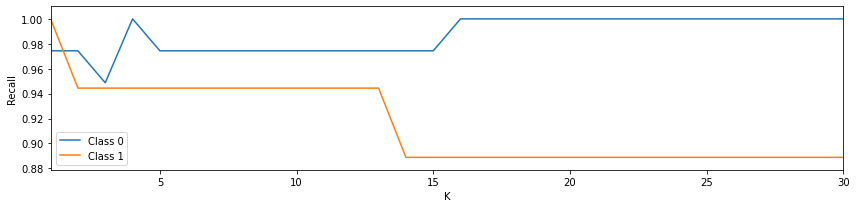

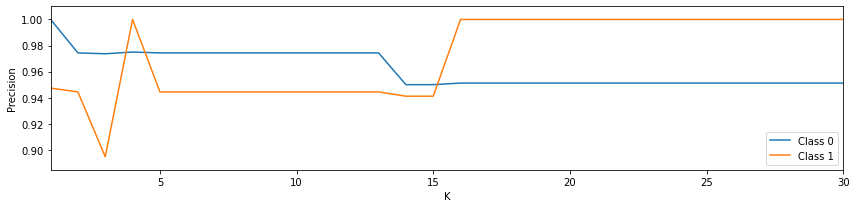

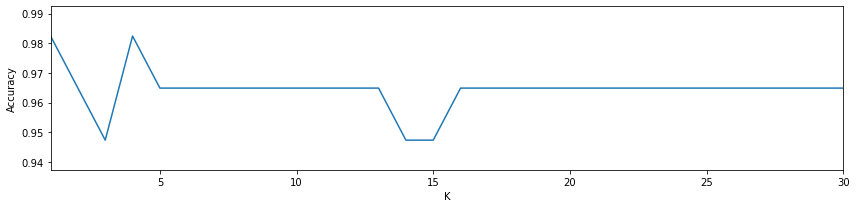

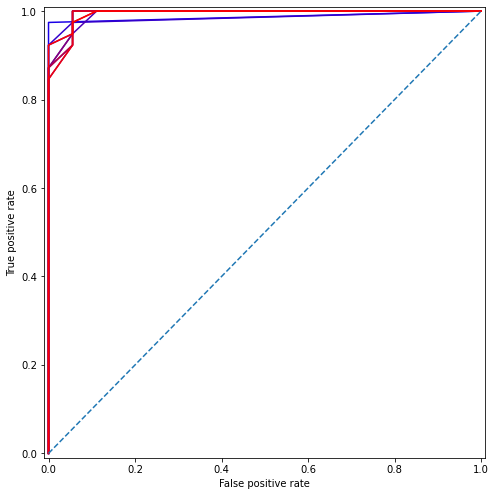

Wall time: 4.33 s


In [48]:
%%time
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

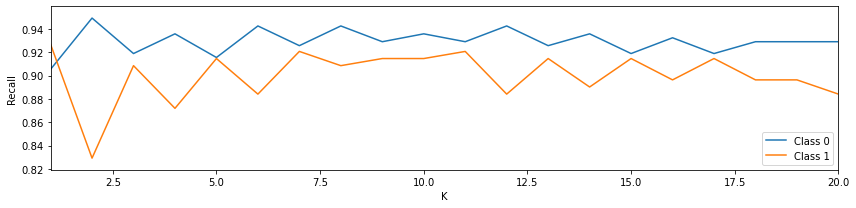

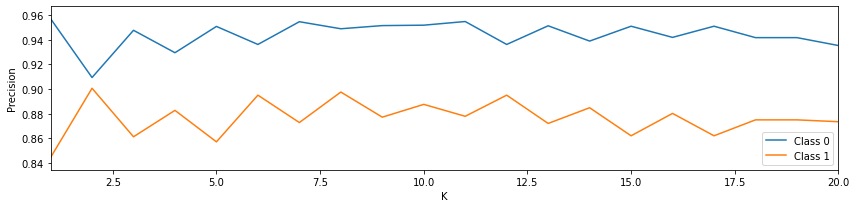

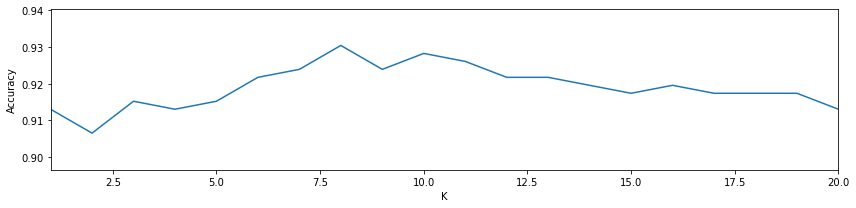

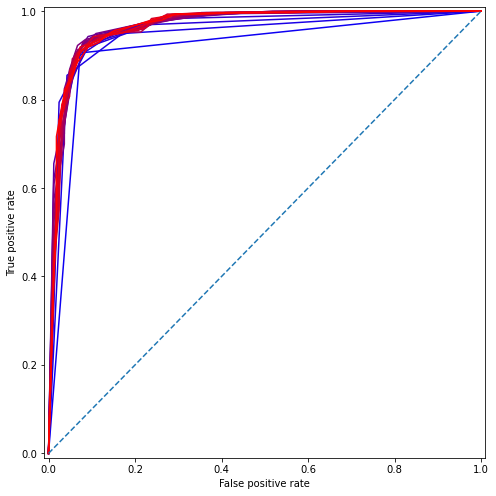

Wall time: 1min 28s


In [49]:
%%time
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)